# Synthetic Sonic Log Generation -- Nilesh Singhal 

* __Author__: _Nilesh Singhal_
* __Date__: June 26th, 2020


- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Summary</a>

<a></a>

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [ ]:
!pip install pyrenn
# import libraries
import pandas as pd
import numpy as np
import pyrenn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import DBSCAN 
from sklearn import metrics 
from sklearn.datasets.samples_generator import make_blobs  
from sklearn import datasets 

  Created wheel for pyrenn: filename=pyrenn-0.1-cp36-none-any.whl size=9258 sha256=cf1bd23e36051b3d4dc53e8d09af95513a4497b70e144ced8fbd94ce99e7f7b1
  Stored in directory: /root/.cache/pip/wheels/91/ed/b6/ab8600223e6ec9cea9592f0cf6e32db7abb4c2cc4c30b90eac
Successfully built pyrenn


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## <a>3. Read Data</a>

<a>Top</a>

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SWPLA_Dataset/train.csv')

## <a>4. Glimps Data</a>

<a>Top</a>

In [ ]:
df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


## <a>5. Exploratory Data Analysis</a>

<a>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

In [ ]:
# remove all rows that contains missing value
df.replace(['-999', -999], np.nan, inplace=True)
df.dropna(axis=0, inplace=True)
df.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000,20525.000000
mean,8.426679,0.274416,49.889253,2.598719,5.835466,3.833792,2.410734,88.312221,182.051067
std,1.845912,3.062495,54.811017,3.465665,422.449589,4.375818,0.181713,23.542419,84.670122
min,5.930400,0.014500,1.038900,0.123600,0.134100,-0.023200,0.680600,49.970500,80.580400
25%,6.629100,0.120300,16.036800,0.810000,0.797300,0.049800,2.236100,70.423100,127.148800
50%,8.578100,0.187700,37.498000,1.814900,1.829300,3.287800,2.466500,79.695400,142.678500
75%,8.671900,0.329000,61.140700,3.337400,3.463300,7.061300,2.563700,102.482800,192.757800
max,21.064200,365.885000,1470.253400,206.718200,60467.761700,28.106400,3.259700,155.980300,487.438400


In [ ]:
np.shape(df)

(20525, 9)

In [ ]:
df.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']

In [ ]:
cal = df.iloc[:, np.r_[0:1]]
cnc = df.iloc[:, np.r_[1:2]]
gr = df.iloc[:, np.r_[2:3]]
hrd = df.iloc[:, np.r_[3:4]]
hrm = df.iloc[:, np.r_[4:5]]
pe = df.iloc[:, np.r_[5:6]]
zden = df.iloc[:, np.r_[6:7]]
dtc = df.iloc[:, np.r_[7:8]]
dts = df.iloc[:, np.r_[8:9]]

### <a>5.1. Method to detect outliers</a>

#### <a>5.1.1. DBSCAN Method</a>

In [ ]:
df1 = df[["GR", "DTC"]]
df2 = df

**DBSCAN**

Estimated number of clusters: 9
Estimated number of noise points: 258


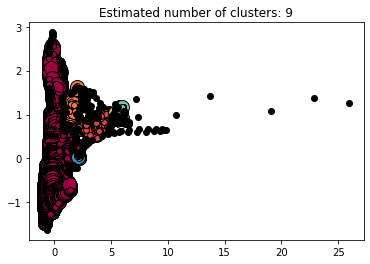

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
X = df1
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
print(len(labels))

20525


#### <a>5.1.2. CBLOF, IF, OCSVM</a>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

OUTLIERS :  1027 INLIERS :  19498 Cluster-based Local Outlier Factor (CBLOF)


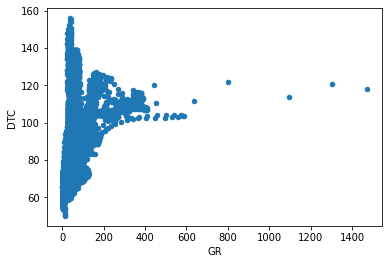

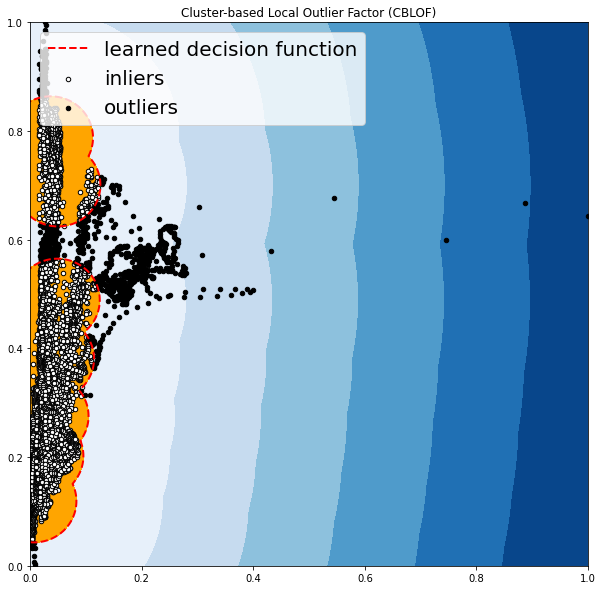

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  1027 INLIERS :  19498 Isolation Forest


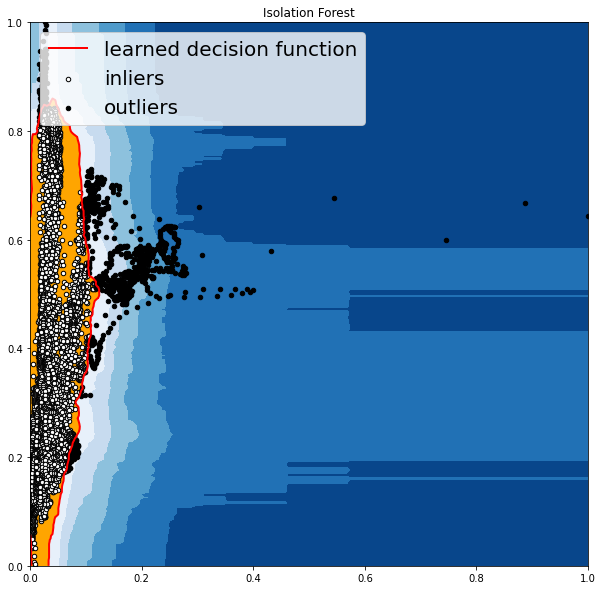

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


OUTLIERS :  2053 INLIERS :  18472 OCSVM


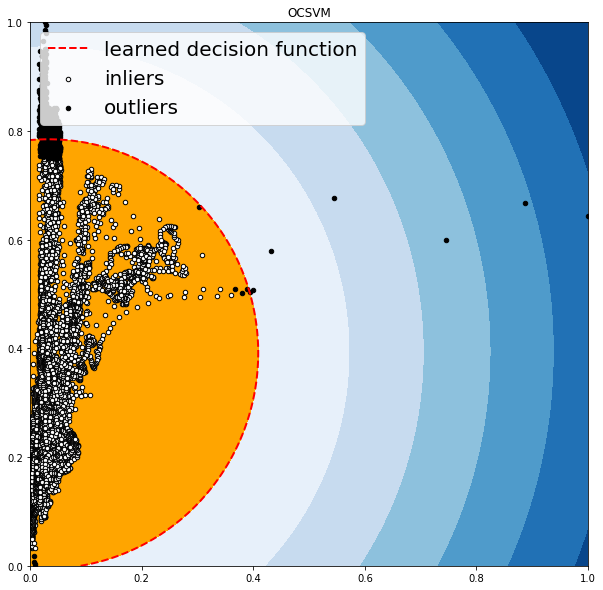

In [ ]:
!pip install pyod
import pandas as pd
import numpy as np
import matplotlib.font_manager
import matplotlib.pyplot as plt

# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from scipy import stats

df1.plot.scatter('GR','DTC')

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df1[['GR','DTC']] = scaler.fit_transform(df1[['GR','DTC']])
df1[['GR','DTC']].head()

X1 = df1['GR'].values.reshape(-1,1)
X2 = df1['DTC'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'OCSVM': OCSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=- 1, contamination=0.1)
}

xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = df1
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['GR'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['DTC'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['GR'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['DTC'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()
    


#### <a>5.1.3. Outliers removal based on thresholding</a>

In [ ]:
df2 = df2[(df2.GR > 0) & (df2.GR  <= 250)]
df2 = df2[(df2.PE > 0) & (df2.PE  <= 8)]
df2 = df2[(df2.ZDEN > 1.95) & (df2.PE  <= 2.95)]
df2.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,9877.000000,9877.000000,9877.000000,9877.000000,9877.000000,9877.000000,9877.000000,9877.000000,9877.000000
mean,8.604316,0.157098,38.188854,3.069097,3.436658,0.057907,2.490076,75.574383,138.297448
std,0.098081,0.082342,39.148741,2.495174,4.203490,0.134492,0.136648,11.577033,23.735519
min,5.984800,0.029000,1.038900,0.129500,0.185300,0.002500,2.125700,56.382300,96.900500
25%,8.578100,0.100100,10.982400,1.213500,1.321700,0.045900,2.431300,67.661100,121.480100
50%,8.625000,0.139200,32.121300,2.633200,2.870200,0.050000,2.541000,72.892800,132.535000
75%,8.625000,0.198700,47.159300,3.738800,4.235900,0.055200,2.584200,80.519800,143.062600
max,8.875000,0.546500,249.581300,16.989200,213.490100,2.931500,2.931500,114.075900,217.970300


#### <a>5.1.4. Z-Score</a>

In [ ]:
# Z-Score
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df2))
print(z)
threshold = 3
print(np.where(z > 3))
df2 = df2[(z < 3).all(axis=1)]

[[17.73642692  0.70200894  0.2627562  ...  2.18291532  1.33383909
   1.04281712]
 [16.57100265  0.74208764  0.24715848 ...  2.25463596  1.49903659
   1.16978939]
 [15.68801277  0.83924812  0.21876277 ...  2.54151851  2.27045638
   1.86699925]
 ...
 [ 0.76863452  0.24656919  2.1423369  ...  0.92815033  0.09494995
   0.24354388]
 [ 0.68910426  0.21013401  2.10650763 ...  0.92083189  0.08488641
   0.2353532 ]
 [ 0.68910426  0.207705    2.10331963 ...  0.91790452  0.07482287
   0.22715832]]
(array([   0,    0,    1,    1,    2,    2,    3,    3,    4,    4,    5,
          5,    6,    6,    7,    7,    8,    8,    9,    9,   10,   10,
         11,   11,   12,   12,   13,   13,   14,   14,   15,   15,   16,
         16,   17,   17,   18,   18,   19,   19,   20,   20,   21,   21,
         22,   22,   23,   23,   24,   24,   24,   24,   25,   25,   26,
         27,   28,   29,   30,   31,   32,   33,   34,   35,   40,   49,
         50,   51,  490,  491,  492,  493,  494,  495,  555,  556,  5

#### <a>5.1.5. IQR</a> 
The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In [ ]:
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

CAL      0.046900
CNC      0.087800
GR      34.553200
HRD      2.371050
HRM      2.758450
PE       0.009200
ZDEN     0.138850
DTC     11.370575
DTS     19.686675
dtype: float64


### <a>5.2 Visualization</a>

#### <a>5.2.1. Scatter Plot</a>

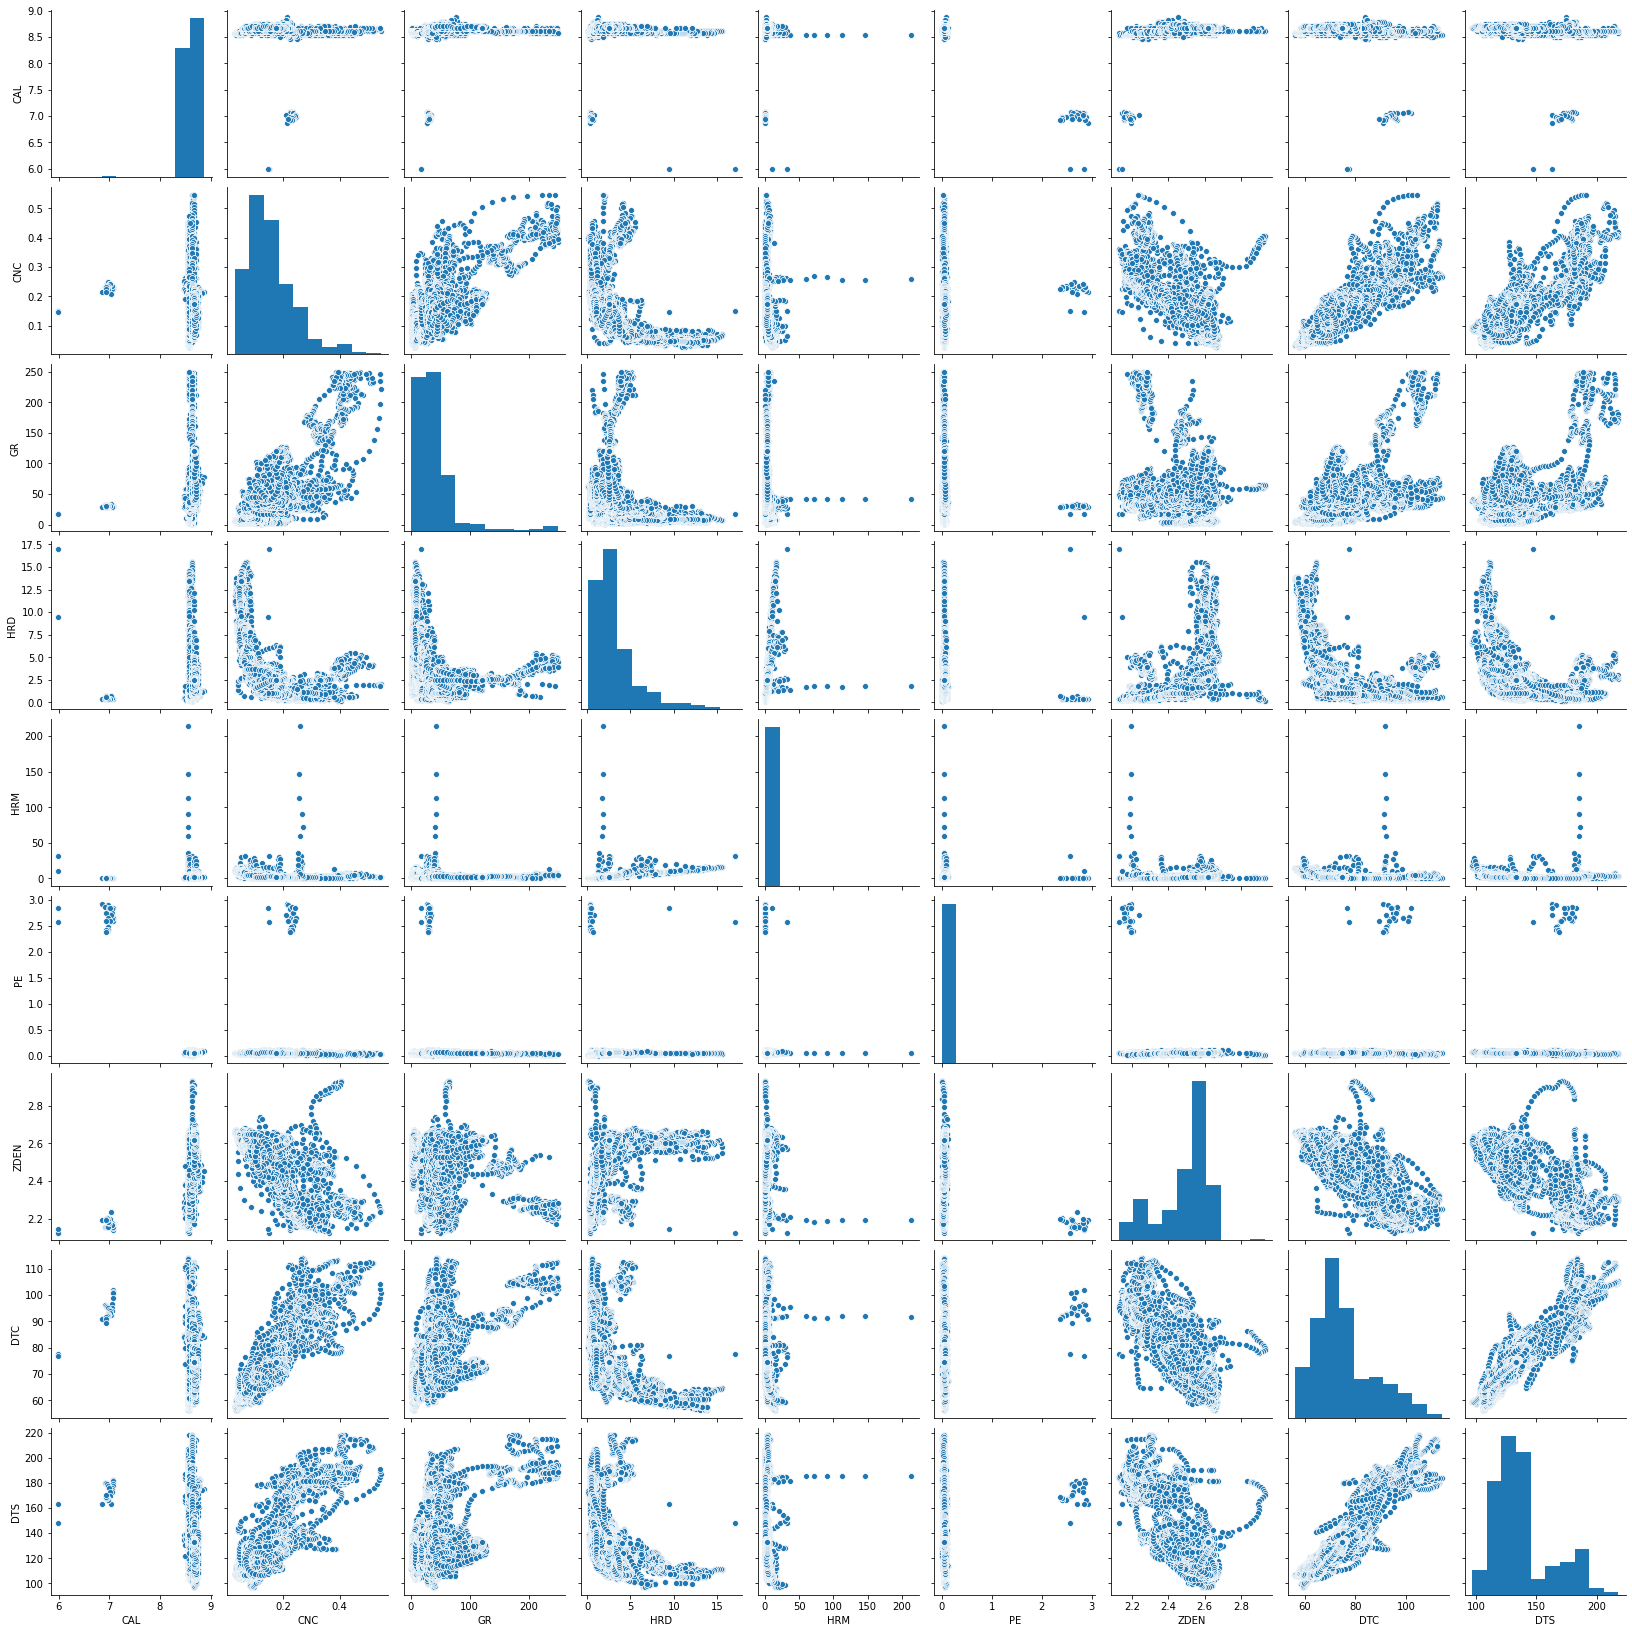

In [ ]:
# Seaborn visualization library
import seaborn as sns# Create the default pairplot
sns.pairplot(df2)


#### <a>5.2.2. Box Plot</a>

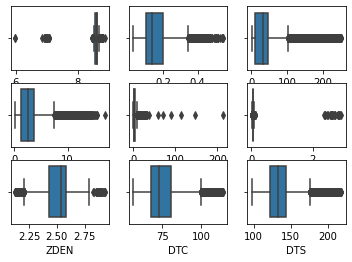

In [ ]:
# Box Plot
# Cut the window with 3 rows and 3 columns:
plt.subplot(331)
sns.boxplot(x=df2['CAL'])
plt.subplot(332)
sns.boxplot(x=df2['CNC'])
plt.subplot(333)
sns.boxplot(x=df2['GR'])
plt.subplot(334)
sns.boxplot(x=df2['HRD'])
plt.subplot(335)
sns.boxplot(x=df2['HRM'])
plt.subplot(336)
sns.boxplot(x=df2['PE'])
plt.subplot(337)
sns.boxplot(x=df2['ZDEN'])
plt.subplot(338)
sns.boxplot(x=df2['DTC'])
plt.subplot(339)
sns.boxplot(x=df2['DTS'])
plt.show()


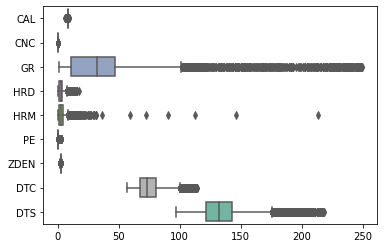

In [ ]:
ax = sns.boxplot(data=df2, orient="h", palette="Set2")

#### <a>5.2.3. Histogram</a>

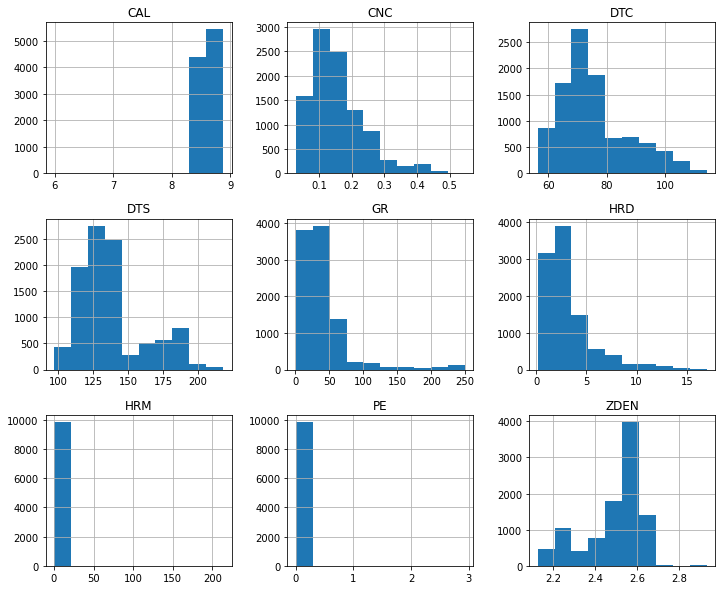

In [ ]:
# Histogram
df2.hist(figsize = (12,10))
plt.show()

#### <a>5.2.4. Heat Map</a>

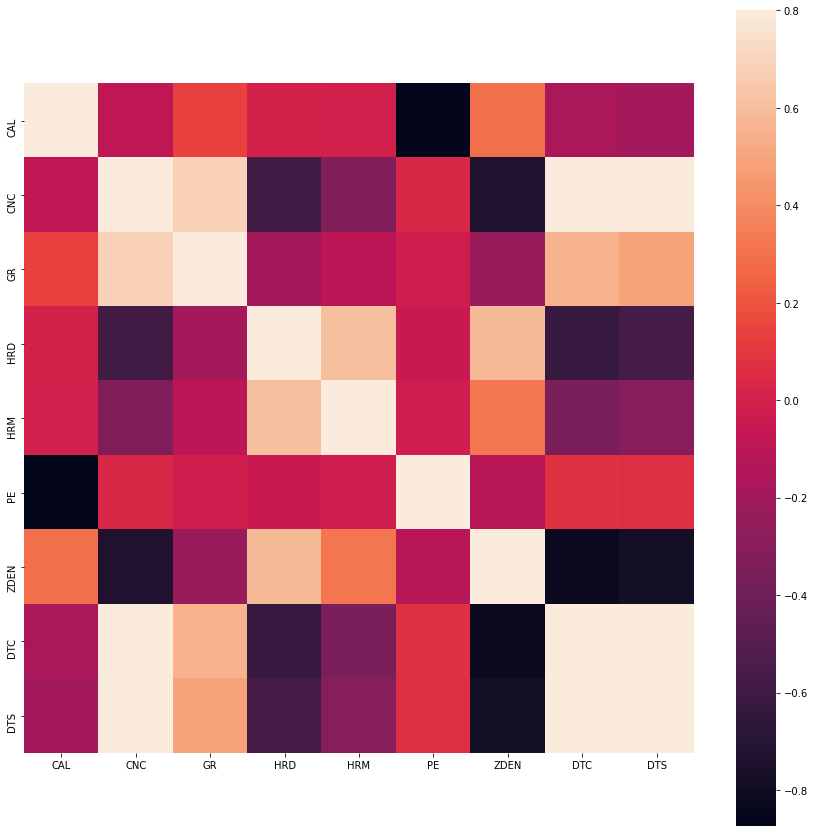

In [ ]:
# Heat Map
C_mat = df2.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

## <a>6. Build Machine Learning Models</a>

<a>Top</a>

In [ ]:
# seperate the features and targets
df2_data = np.array(df2)
y_trainwell1 = df2_data[:,-2:]
x_trainwell1 = df2_data[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [ ]:
print(y_trainwell1[:5][:])

[[ 91.4708 184.2692]
 [ 91.3414 183.9954]
 [ 91.212  183.7216]
 [ 91.1957 183.5995]
 [ 91.2143 183.4239]]


In [ ]:
np.shape(y_trainwell1)

(9218, 2)

In [ ]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)


In [ ]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [ ]:
def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

0.8319621599665258
Root Mean Square Error is: 7.45078


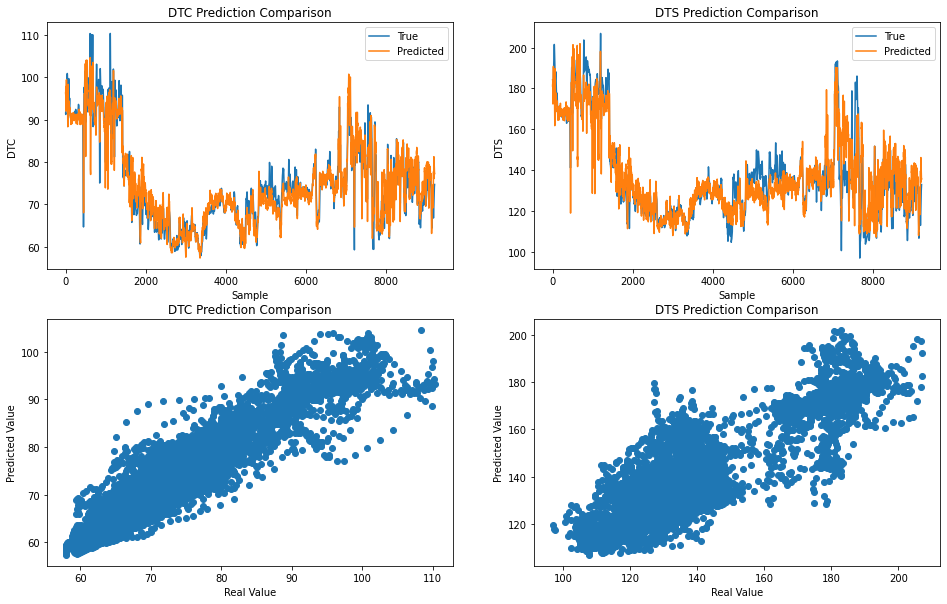

In [ ]:
# Linear regression model as the baseline
LR = LinearRegression()
LR_best = grid_search(LR, {})
LR_predict = LR_best.predict(x_trainwell1)
result_plot(LR_predict, y_trainwell1)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Accuracy Score is: 0.80399
Root Mean Square Error is: 7.45075


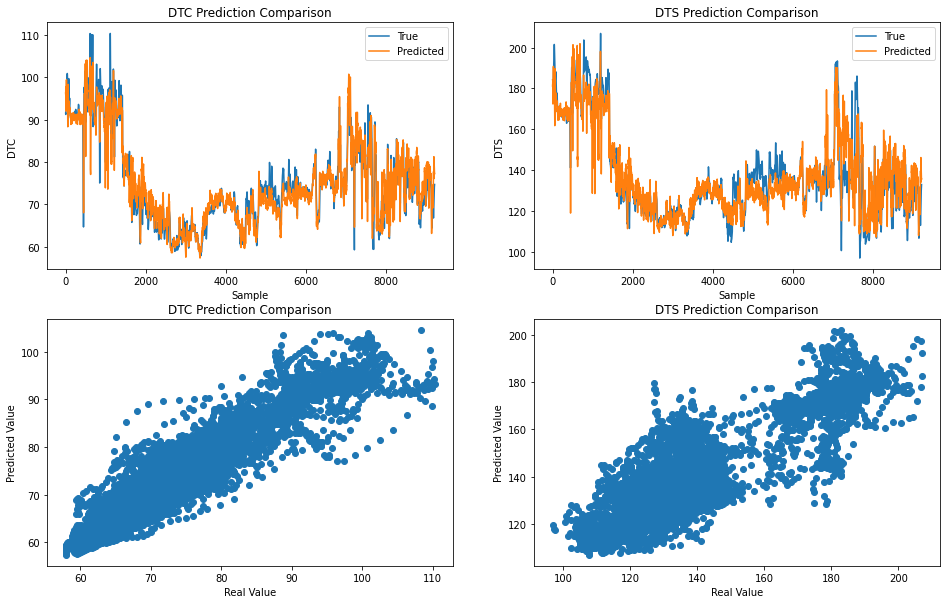

In [ ]:
# Add ridge regularization, and see if there's any improvement
ridge = RidgeCV(cv=6, alphas=[1e-3, 1e-2, 1e-1, 1], )
ridge.fit(X_train, y_train)
print('Accuracy Score is:', '{:.5f}'.format(ridge.score(X_train, y_train)))
result_plot(ridge.predict(x_trainwell1), y_trainwell1)

0.9391240370464861
Root Mean Square Error is: 2.26630


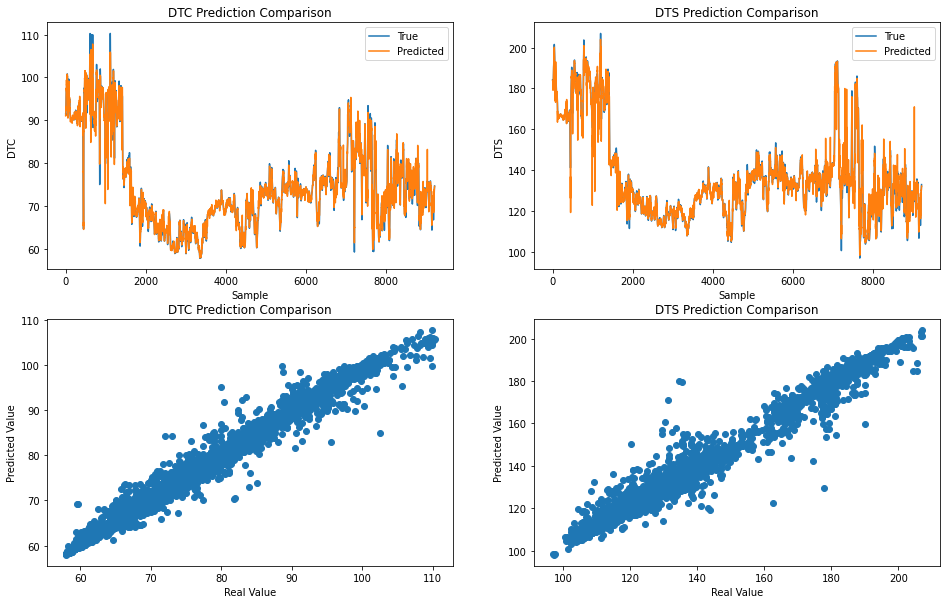

In [ ]:
# Random forest model
RF = RandomForestRegressor(n_estimators=200, random_state=100)
RF_best = grid_search(RF, {})
result_plot(RF_best.predict(x_trainwell1), y_trainwell1)

**Hypertuning Random Forest**

In [ ]:
from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(RF.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

RF_best = grid_search(RF, param_grid, x_trainwell1, y_trainwell1)

Root Mean Square Error is: 4.03795


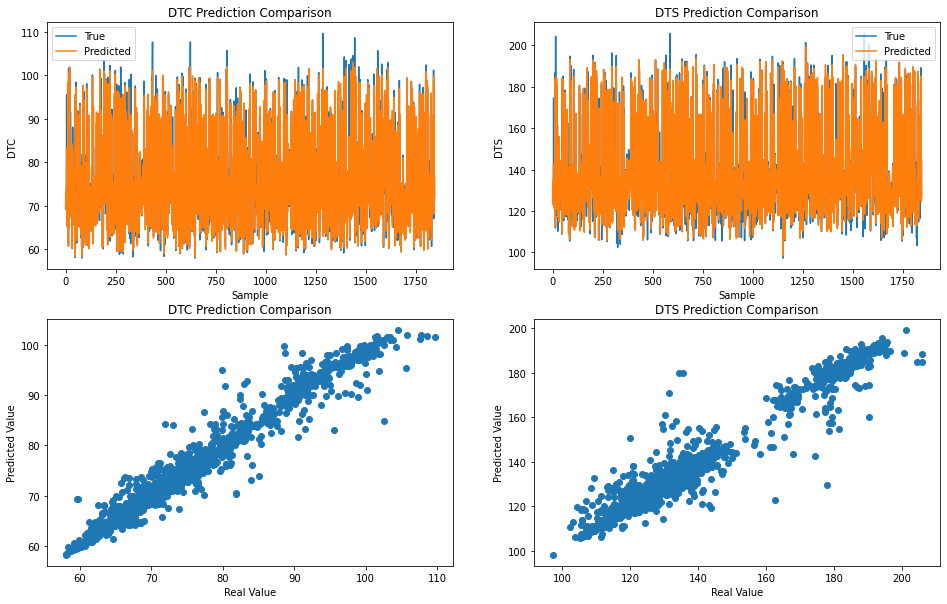

In [ ]:
# check the result on test dataset only
result_plot(RF_best.predict(X_test), y_test)

## <a>7. Prediction</a>

<a>Top</a>

In [ ]:
# load test data from well 2
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SWPLA_Dataset/test.csv')
# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan
df2.dropna(axis=0, inplace=True)
df2_data = np.array(df2)
x_trainwell2 = df2_data
x_trainwell2 = scaler.transform(x_trainwell2)
#print(y_trainwell2.head())
print(x_trainwell2[:5][:])

[[-0.26729817  2.36831118  0.43409843 -0.90459074 -0.63180652 50.34893849
  -1.20370905]
 [-0.26729817  2.51162289  0.48082005 -0.90791733 -0.63387633 50.20691554
  -1.2044409 ]
 [-0.26729817  2.58935128  0.52973597 -0.93172449 -0.64993523 49.95856128
  -1.23591016]
 [-0.4263587   2.54562906  0.48897909 -0.94274632 -0.66197345 49.5518254
  -1.30397158]
 [-0.26729817  2.34280656  0.37994324 -0.95573204 -0.67227494 48.93093974
  -1.4042341 ]]


In [ ]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

array([[ 97.130307, 180.201364],
       [ 97.656947, 181.125657],
       [ 98.448604, 180.612511],
       [ 99.345962, 179.961073],
       [ 98.871248, 177.42397 ]])

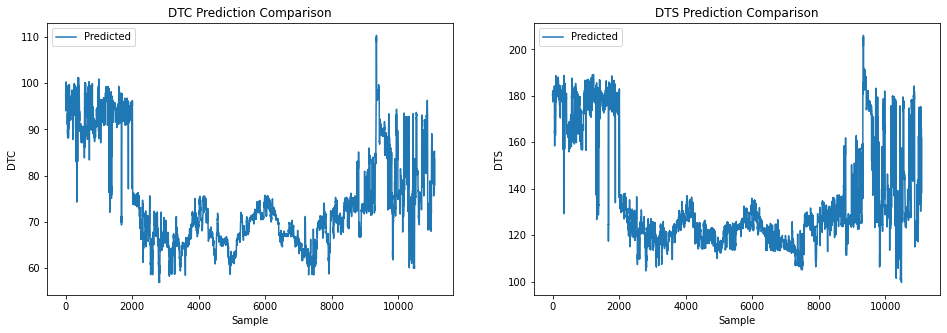

In [ ]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [ ]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

,DTC,DTS
0,97.130307,180.201364
1,97.656947,181.125657
2,98.448604,180.612511
3,99.345962,179.961073
4,98.871248,177.423970


In [ ]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='/content/drive/My Drive/Colab Notebooks/SWPLA_Dataset/sample_submission.csv', index=False)

**ANN Model**  

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow import keras

X = df.iloc[:, np.r_[0:7]]
Y_DTC = df.iloc[:, np.r_[7:8]]
Y_DTS = df.iloc[:, np.r_[8:9]]

#Splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train_DTC, Y_test_DTC = train_test_split(X, Y_DTC, test_size = 0.2, random_state = 0)
X_train, X_test, Y_train_DTS, Y_test_DTS = train_test_split(X, Y_DTS, test_size = 0.2, random_state = 0)
Y_test = np.concatenate([Y_test_DTC, Y_test_DTS], 1) 

# Feature Scaling (Normalization)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
print(X)
print(Y_DTC)
print(Y_DTS)
print(Y_test)

Num GPUs Available:  1
           CAL     CNC        GR     HRD     HRM       PE    ZDEN
573    14.8824  0.5173   57.1903  1.9826  1.9726  27.9432  2.3510
574    14.9570  0.4966   63.1593  2.0472  1.6373  28.1064  2.4055
575    14.6341  0.4433   64.5217  2.0464  1.4866  26.5968  2.4579
576    14.2318  0.4309   63.0144  2.0054  1.4613  19.5635  2.4219
577    14.0163  0.4469   60.8421  1.9533  1.4438   9.8556  2.3138
...        ...     ...       ...     ...     ...      ...     ...
30138   8.6719  0.1879  119.9486  2.5130  2.5187   0.0597  2.6240
30139   8.6719  0.1825  122.5286  2.5011  2.4818   0.0582  2.6194
30140   8.6797  0.1774  122.0544  2.5010  2.4717   0.0571  2.6169
30141   8.6719  0.1744  120.6518  2.5150  2.5007   0.0562  2.6159
30142   8.6719  0.1742  120.5270  2.5211  2.5068   0.0552  2.6155

[20525 rows x 7 columns]
            DTC
573    125.9611
574    125.9726
575    125.8528
576    125.7362
577    125.9774
...         ...
30138   74.2133
30139   74.3503
30140   74.4752

In [ ]:
# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#Initialize the ANN
regressor = Sequential()

# Adding input layer and first hidden layer
regressor.add(Dense(units = 128, kernel_initializer='normal', activation='tanh', input_dim=X_train.shape[1]))
# Should apply dropout to each layer, it is used to avoid overfitting 
# Adding dropout to first hidden layer, rate is fraction of number of nodes we want to randomly disable, if rate is more than 0.5, we will have underfitting
regressor.add(Dropout(rate = 0.001))

# Adding 2nd hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='tanh'))
# Adding dropout to second layer
regressor.add(Dropout(rate = 0.001))

# Adding 3rd hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='tanh'))
# Adding dropout to third layer
regressor.add(Dropout(rate = 0.001))

# Adding 4th hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='tanh'))
# Adding dropout to fourth layer
regressor.add(Dropout(rate = 0.001))

# Adding 5th hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
# Adding dropout to fifth layer
regressor.add(Dropout(rate = 0.001))

# Adding 6th hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
# Adding dropout to sixth layer
regressor.add(Dropout(rate = 0.001))

# Adding 7th hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
# Adding dropout to eighth layer
regressor.add(Dropout(rate = 0.001))

# Adding 8th hidden layer
regressor.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
# Adding dropout to eight layer
regressor.add(Dropout(rate = 0.001))

# Adding Output layer
regressor.add(Dense(units = 1, kernel_initializer='normal', activation='linear'))

# Compiling the ANN (Applying Stochastic Gradient Descent Algorithm (adam) for backpropogation on whole ANN)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [ ]:
regressor1 = Sequential()
regressor1.add(Dense(units = 128, kernel_initializer='normal', activation='tanh', input_dim=(X_train.shape[1])))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='tanh'))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='tanh'))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='tanh'))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
regressor1.add(Dense(units = 256, kernel_initializer='normal', activation='relu'))
regressor1.add(Dense(units = 1, kernel_initializer='normal', activation='linear'))
regressor1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
regressor1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
callbacks_list= tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

**DTC**

Epoch 1/1000
 87/103 [========================>.....] - ETA: 0s - loss: 1283.0438 - mean_squared_error: 1283.0438
Epoch 00001: saving model to training_1/cp.ckpt
103/103 [==============================] - 1s 5ms/step - loss: 1089.2749 - mean_squared_error: 1093.1377 - val_loss: 35.9026 - val_mean_squared_error: 35.9213
Epoch 2/1000
 87/103 [========================>.....] - ETA: 0s - loss: 27.3648 - mean_squared_error: 27.3648
Epoch 00002: saving model to training_1/cp.ckpt
103/103 [==============================] - 0s 4ms/step - loss: 27.4049 - mean_squared_error: 27.3961 - val_loss: 29.2741 - val_mean_squared_error: 29.2503
Epoch 3/1000
100/103 [============================>.] - ETA: 0s - loss: 26.6656 - mean_squared_error: 26.6656
Epoch 00003: saving model to training_1/cp.ckpt
103/103 [==============================] - 0s 4ms/step - loss: 26.4587 - mean_squared_error: 26.4906 - val_loss: 29.2506 - val_mean_squared_error: 29.2155
Epoch 4/1000
100/103 [============================>.]

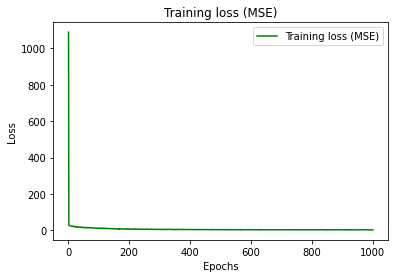

In [ ]:
# fitting the ANN to our training set
regressor.fit(X_train, Y_train_DTC, batch_size = 128, epochs = 1000, validation_split = 0.2, callbacks=callbacks_list)

loss_train = regressor.history.history['loss']
epochs = range(1,1001)
plt.plot(epochs, loss_train, 'g', label='Training loss (MSE)')
plt.title('Training loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**DTS**

Epoch 1/1000
193/206 [===========================>..] - ETA: 0s - loss: 4552.2129 - mean_squared_error: 4552.2129
Epoch 00001: saving model to training_1/cp.ckpt
206/206 [==============================] - 1s 4ms/step - loss: 4295.8022 - mean_squared_error: 4310.3320 - val_loss: 559.4639 - val_mean_squared_error: 561.5715
Epoch 2/1000
197/206 [===========================>..] - ETA: 0s - loss: 548.2145 - mean_squared_error: 548.2145
Epoch 00002: saving model to training_1/cp.ckpt
206/206 [==============================] - 1s 3ms/step - loss: 543.3445 - mean_squared_error: 544.6577 - val_loss: 510.6945 - val_mean_squared_error: 513.1568
Epoch 3/1000
198/206 [===========================>..] - ETA: 0s - loss: 492.8446 - mean_squared_error: 492.8446
Epoch 00003: saving model to training_1/cp.ckpt
206/206 [==============================] - 1s 3ms/step - loss: 491.8543 - mean_squared_error: 492.5416 - val_loss: 438.7505 - val_mean_squared_error: 440.6445
Epoch 4/1000
195/206 [=================

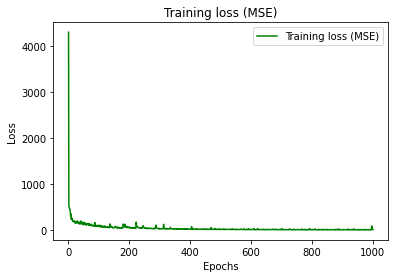

In [ ]:
# fitting the ANN to our training set
regressor1.fit(X_train, Y_train_DTS, batch_size = 64, epochs = 1000, validation_split = 0.2, callbacks=callbacks_list)

loss_train = regressor1.history.history['loss']
epochs = range(1,1001)
plt.plot(epochs, loss_train, 'g', label='Training loss (MSE)')
plt.title('Training loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Root Mean Square Error is: 7.22298


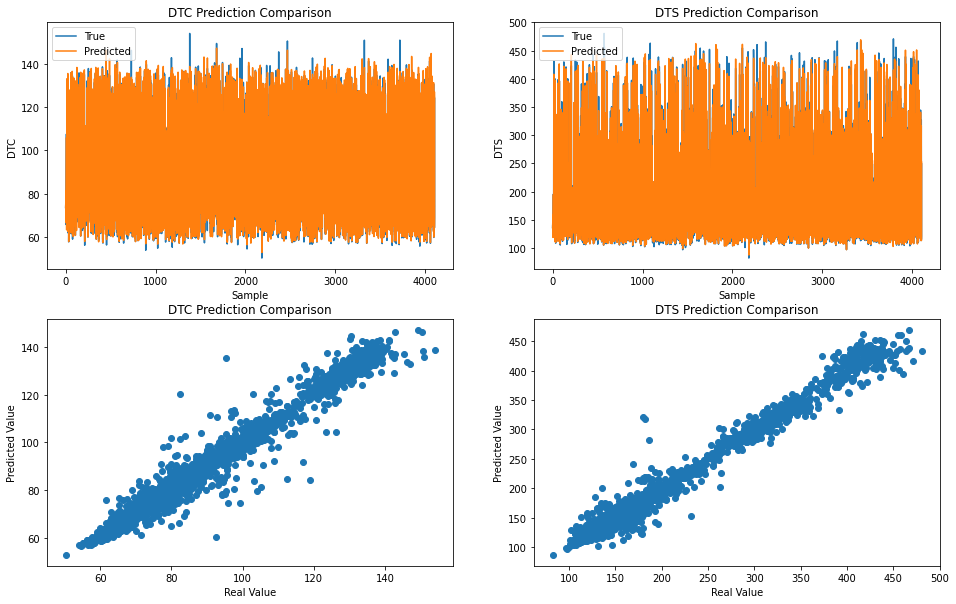

In [ ]:
# Part 3 Making the predictions and evaluating the model
Y_pred_test_DTC = regressor.predict(X_test)
Y_pred_test_DTS = regressor1.predict(X_test)
Y_pred = np.concatenate([Y_pred_test_DTC, Y_pred_test_DTS], 1)
result_plot(Y_pred, Y_test)

In [ ]:
# Part 4 - Evaluating, Improving and Tuning the ANN
# K-Fold CV uses scikit library, we have to use keras classifier wrapper to wrap scikit with keras and use our tensorflow backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

# Defining function
def build_classifier(): # This function returns a classifier
    classifier = Sequential()    
    classifier.add(Dense(units = 7, kernel_initializer='uniform', activation='relu', input_dim=13))
    classifier.add(Dense(units = 7, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units = 1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier # This a local classifier within the function, so this classifier will only be existing within the function thus we have to create a new global classifer
# New global classifier will be trained using K-Fold Cross Validation, other than that the architecture of our NN is same
# Wrapping scikit with Keras
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)    
# Accuracies will contain the different accuracies given by each fold after validation
# cv is number of folds, n_job is the amount of computational power we require, n_jobs = -1 uses all the computational power available, calculated different folds simultaneously
# Our model will now train 10 times (depending in number of folds)
# Same epoch runs on different folds
accuracies = cross_val_score(estimator = classifier, X = X_train, y = Y_train, cv = 10, n_jobs = -1)
# Mean accuracy after K-Fold CV mode is used for training
mean = accuracies.mean()
variance = accuracies.std()

In [ ]:
# Tuning the ANN (Grid search technique)
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
def build_classifier(optimizer): 
    classifier = Sequential()    
    classifier.add(Dense(units = 7, kernel_initializer='uniform', activation='relu', input_dim=13))
    classifier.add(Dense(units = 7, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units = 1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier 
# Batch size and epoch numbers are to be tuned here
classifier = KerasClassifier(build_fn = build_classifier)
# Now create a dictionary of hyperparameters which is needed to be tuned
# We will put the values of hyperparameters for which we need to tune
parameters = {"batch_size": [25, 32], "epochs": [100, 500], "optimizer": ['adam', 'rmsprop']}
# Creating Grid search object to tune our hyperparameters
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10)
# Fitting the NN to test set to tune the parameters
grid_search = grid_search.fit(X_train, Y_train) 
# To extract the best parameters found by grid search CV
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

**XG Boost Method**
      

In [ ]:
X = df1.iloc[:, np.r_[0:7]]
Y_DTC = df1.iloc[:, np.r_[7:8]]
Y_DTS = df1.iloc[:, np.r_[8:9]]

#Splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train_DTC, Y_test_DTC = train_test_split(X, Y_DTC, test_size = 0.2, random_state = 0)
X_train, X_test, Y_train_DTS, Y_test_DTS = train_test_split(X, Y_DTS, test_size = 0.2, random_state = 0)

# Feature Scaling (Normalization)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [ ]:
#DTC
XGBModel_DTC = XGBRegressor()
XGBModel_DTC.fit(X_train,Y_train_DTC , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions_DTC = XGBModel_DTC.predict(X_test)
MAE = mean_absolute_error(Y_test_DTC, XGBpredictions_DTC)
print('XGBoost validation MAE for DTC= ',MAE)
print(XGBpredictions_DTC)

[16:50:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE for DTC=  1.7579307564394075
[67.77908  64.3425   70.200386 ... 77.00245  68.199234 71.73094 ]


In [ ]:
#DTS
XGBModel_DTS = XGBRegressor()
XGBModel_DTS.fit(X_train,Y_train_DTS , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions_DTS = XGBModel_DTS.predict(X_test)
MAE = mean_absolute_error(Y_test_DTS, XGBpredictions_DTS)
print('XGBoost validation MAE for DTS= ',MAE)
print(XGBpredictions_DTS)

[16:50:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE for DTS=  4.576924190450077
[124.399574 119.25019  117.36997  ... 132.64616  125.591034 131.78528 ]



**Mean Square Error for hidden dataset (Random Forrest)**



In [ ]:
# load test data from hidden dataset
df3 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SWPLA_Dataset/real_result_20perc.csv')
# Remove missing 
for col in df3.columns.tolist():
    df3[col][df3[col]==-999] = np.nan
df3.dropna(axis=0, inplace=True)
df3_data = np.array(df3)

#df3 = df3[(df3.GR > 0) & (df3.GR  <= 250)]
#df3 = df3[(df3.PE > 0) & (df3.PE  <= 8)]
#df3 = df3[(df3.ZDEN > 1.95) & (df3.PE  <= 2.95)]

#z = np.abs(stats.zscore(df3))
#print(z)
#threshold = 3
#df3 = df3[(z < 3).all(axis=1)]

x_hidden = df3_data[:,:-2]
y_hidden_true = df3_data[:,-2:]
x_hidden1 = scaler.transform(x_hidden) 

In [ ]:
y_hidden_predict = RF_best.predict(x_hidden1)
print(y_hidden_predict)
print(y_hidden_true)

[[ 70.454615  122.5947555]
 [ 90.972049  154.035241 ]
 [ 94.9178825 183.2937375]
 ...
 [ 91.9934225 167.812632 ]
 [ 63.330647  116.8391915]
 [ 68.0809745 122.947661 ]]
[[ 67.5481 124.2332]
 [101.5208 201.2649]
 [110.8297 250.7232]
 ...
 [ 93.0115 161.6765]
 [ 61.3967 112.0019]
 [ 73.7051 137.8335]]


Root Mean Square Error is: 21.69400


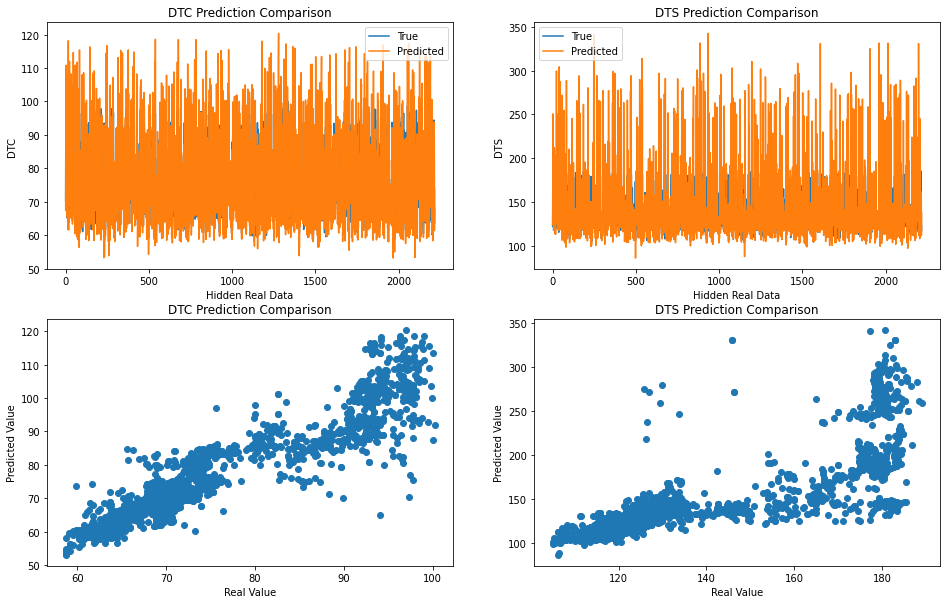

In [ ]:
# check the accuracy of predicted data and plot the result for hidden dataset
result_plot1(y_hidden_true, y_hidden_predict)

**Mean Square Error for hidden dataset (XGBoost)**

In [ ]:
# load test data from hidden dataset
df6 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SWPLA_Dataset/real_result_20perc.csv')
# Remove missing 
for col in df6.columns.tolist():
    df6[col][df6[col]==-999] = np.nan
df6.dropna(axis=0, inplace=True)
df6_data = np.array(df6)

df6 = df6[(df6.GR > 0) & (df6.GR  <= 250)]
df6 = df6[(df6.PE > 0) & (df6.PE  <= 8)]
df6 = df6[(df6.ZDEN > 1.95) & (df6.PE  <= 2.95)]

z = np.abs(stats.zscore(df6))
threshold = 3
df6 = df6[(z < 3).all(axis=1)]

x_hidden = df6_data[:, np.r_[0:7]]
y_hidden_true_DTC = df6_data[:, 7:8]
y_hidden_true_DTS = df6_data[:, 8:9]
y_hidden_true = df6_data[:,-2:]
x_hidden1 = scaler.transform(x_hidden) 
print(y_hidden_true)

[[ 67.5481 124.2332]
 [101.5208 201.2649]
 [110.8297 250.7232]
 ...
 [ 93.0115 161.6765]
 [ 61.3967 112.0019]
 [ 73.7051 137.8335]]


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2416: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
# DTC
y_hidden_predicted_DTC = np.transpose(XGBModel_DTC.predict(x_hidden1)[np.newaxis])
# DTS
y_hidden_predicted_DTS = np.transpose(XGBModel_DTS.predict(x_hidden1)[np.newaxis])
y_hidden_predicted = np.concatenate([y_hidden_predicted_DTC, y_hidden_predicted_DTS], 1) 
print(y_hidden_predicted)

[[ 67.447395 121.12317 ]
 [ 83.588    149.67216 ]
 [ 85.20631  160.77716 ]
 ...
 [ 87.53534  166.362   ]
 [ 60.88474  115.317856]
 [ 68.771866 125.378716]]


In [ ]:
# check the accuracy of predicted data DTC
print('Root Mean Square Error for DTC is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_hidden_true_DTC, y_hidden_predicted_DTC))))
# check the accuracy of predicted data DTS
print('Root Mean Square Error for DTS is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_hidden_true_DTS, y_hidden_predicted_DTS))))

Root Mean Square Error for DTC is: 7.10705
Root Mean Square Error for DTS is: 30.77594


**RMSE Error Final (XGBoost)**

Root Mean Square Error is: 22.33460


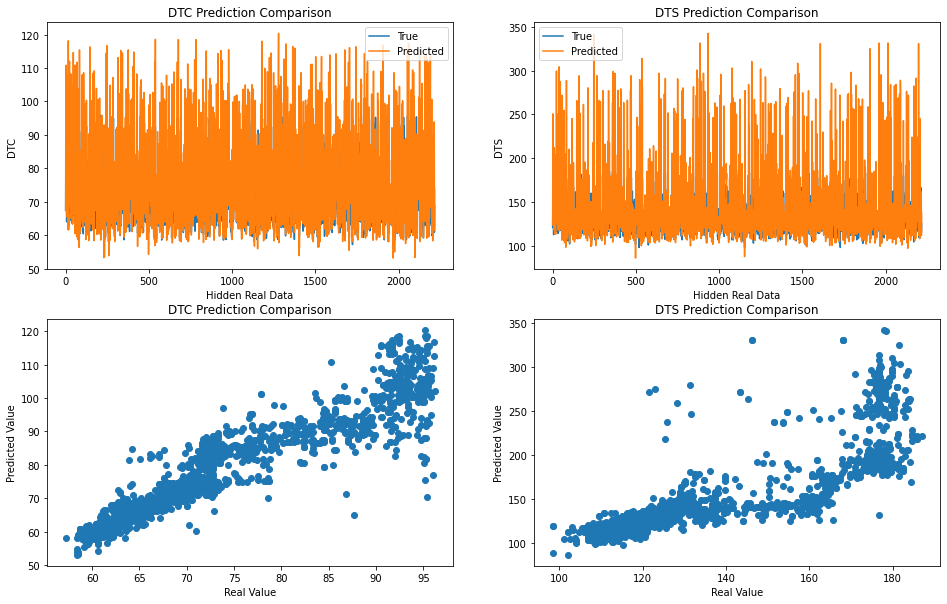

In [ ]:
# check the accuracy of predicted data and plot the result for the hidden dataset
result_plot1(y_hidden_true, y_hidden_predicted)

**Mean Square Error for hidden dataset (ANN)**

In [ ]:
# Importing the dataset
df7 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SWPLA_Dataset/real_result_20perc.csv')
# Remove missing 
for col in df7.columns.tolist():
    df7[col][df7[col]==-999] = np.nan
df7.dropna(axis=0, inplace=True)
df7_data = np.array(df7)
x_hidden = df7.iloc[:, np.r_[0:7]]
y_hidden_true_DTC = df7.iloc[:, np.r_[7:8]]
y_hidden_true_DTS = df7.iloc[:, np.r_[8:9]]
y_hidden_true = df7_data[:,-2:]
# Feature Scaling (Normalization)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_hidden1 = sc_X.fit_transform(x_hidden)

In [ ]:
# Predicting using hidden dataset
y_hidden_predicted_DTC = regressor.predict(x_hidden1)
y_hidden_predicted_DTS = regressor1.predict(x_hidden1)
y_hidden_predicted = np.concatenate([y_hidden_predicted_DTC, y_hidden_predicted_DTS], 1)

In [ ]:
print('Root Mean Square Error for DTC is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_hidden_true_DTC, y_hidden_predicted_DTC))))
print('Root Mean Square Error for DTS is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_hidden_true_DTS, y_hidden_predicted_DTS))))

Root Mean Square Error for DTC is: 15.54558
Root Mean Square Error for DTS is: 51.32093


Root Mean Square Error is: 37.91769


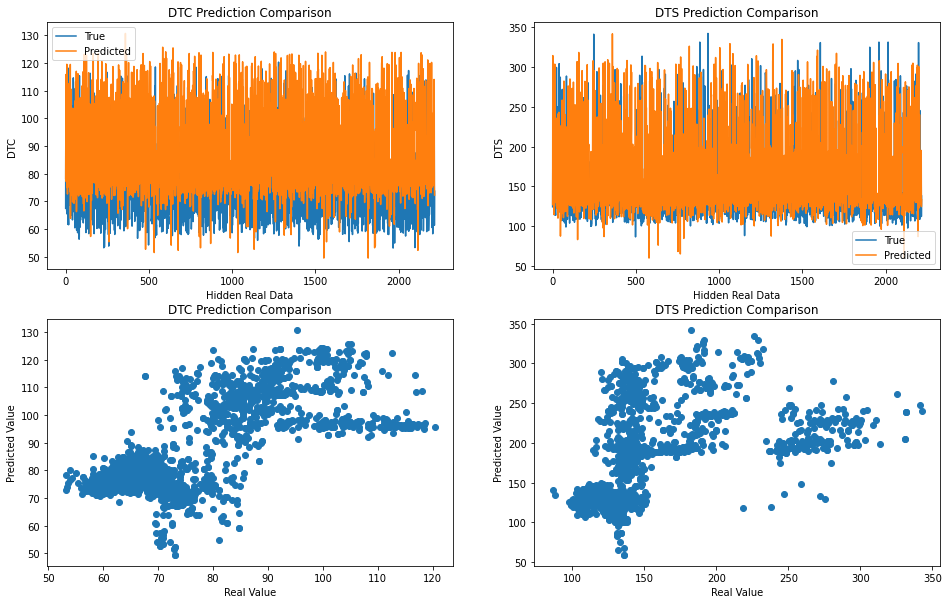

In [ ]:
# check the accuracy of predicted data and plot the result for the hidden dataset
result_plot1(y_hidden_predicted, y_hidden_true)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## <a>8. Summary</a>

<a>Top</a>

Put your ideas, findings, insights, suggestions, and references here